## Задание: обучить resnet различать котов и собак

## Подгрузим необходимое

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install wandb
!pip install pytorch-lightning

In [ ]:
# !wandb login

In [ ]:
# wandb.init(project="cats-dogs", entity="c-nemo")

In [ ]:
import torch

from torch.utils.data import DataLoader, random_split

from torchvision import datasets
from torchvision import transforms
import torchvision.models as models

import matplotlib.pyplot as plt

from torch import nn
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import f1_score
from numpy import argmax, array
from scipy.io import loadmat

import numpy as np

import wandb

In [ ]:
from torch.optim.lr_scheduler import StepLR

## Константы

In [ ]:
ROOT = 'train_val_test/PetImages'

VAL_SIZE = 0.1

BATCH_SIZE = 256
EPOCHS = 1

RESCALE_SIZE = 224
DATA_MODES = ['train', 'val', 'test']

LABELS_LIST = ['Cat','Dog']

TRANSFORM = {
    
    'train_without_normaliz': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),

    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),

        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

## Датасет

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/datasets/archive.zip'

Mounted at /content/drive


In [ ]:
!unzip -q /content/drive/My\ Drive/datasets/archive.zip -d train_val_test

### Чистка

In [ ]:
!find train_val_test/PetImages/Dog -name '._*' -print

In [ ]:
!find train_val_test/PetImages/Dog -name '11702.jpg' -delete

In [ ]:
!find train_val_test/PetImages/Cat -name '666.jpg' -delete

### Для наглядности применим все преобразования, кроме нормализации, к картинкам

In [ ]:
dataset_demo = datasets.ImageFolder(root=ROOT, transform=TRANSFORM['train_without_normaliz'])

In [ ]:
def show_samples(dataset, n):
        figure = plt.figure(figsize=(10, 10))
        cols, rows = n, n
        for i in range(1, cols * rows + 1):

            sample_idx = torch.randint(len(dataset), size=(1,)).item()
            img, label = dataset[sample_idx]

            figure.add_subplot(rows, cols, i)
            plt.title(LABELS_LIST[label])
            plt.axis("off")
            
            plt.imshow(transforms.ToPILImage()(img), cmap="gray")

        plt.show()

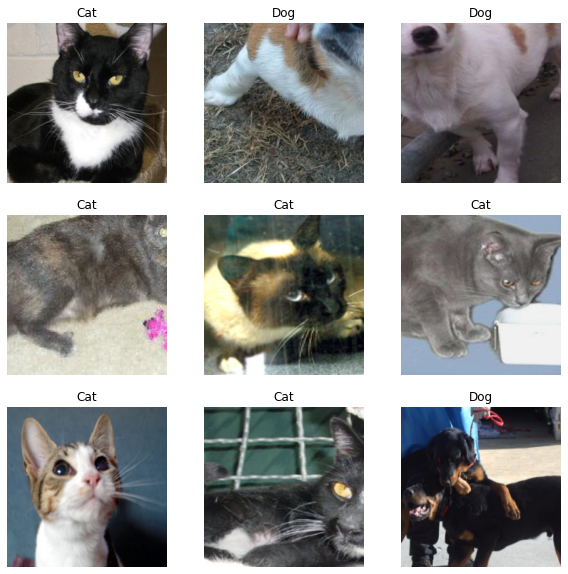

In [ ]:
show_samples(dataset_demo, 3)

### Но в модель будут подаваться уже нормализованные тензоры

In [ ]:
train_val_dataset = datasets.ImageFolder(root=ROOT, transform=TRANSFORM['train'])

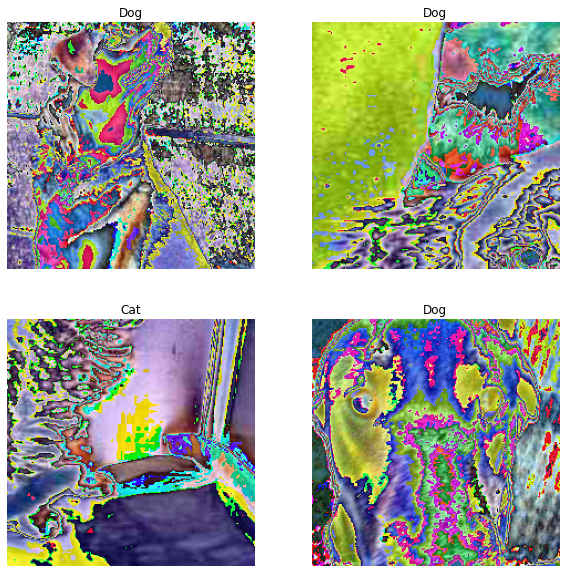

In [ ]:
show_samples(train_val_dataset, 2)

In [ ]:
len_data = len(train_val_dataset)
len_data

24998

Разобьем данные на train и val

In [ ]:
val_size = int(VAL_SIZE * len_data)
train_size = len_data - val_size

In [ ]:
train_dataset, val_dataset = random_split(train_val_dataset, (train_size, val_size))

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) # bs was 1, why

# Классификатор

In [ ]:
class Classifier(pl.LightningModule):
      
    def __init__(self, model):
      
            super().__init__()
            self.model = model
            self.loss_func = nn.CrossEntropyLoss()

            self.accs = {'train': [], 'val': []}
            self.losses = {'train': [], 'val': []}
            self.best_val_acc = 0

    def loss_acc_train_val(self, batch):

            x, y = batch
            pred = self.model(x)
            
            loss = self.loss_func(pred, y)
            _, pred = torch.max(pred.data, 1)
            
            accuracy =  f1_score(
                                y.detach().cpu().numpy(),
                                pred.detach().cpu().numpy(),
                                average='macro')
            
            return loss, accuracy

    '''
    def loss_acc_2(self, batch):

            x, y = batch
            pred = self.model(x)

            target = torch.zeros_like(pred).float()
            target[:, y] = 1.

            loss = F.cross_entropy(target, pred)
        
            y_pred = (pred > 0.5).float()
            accuracy = f1_score(
                                target.cpu(),
                                y_pred.cpu(), 
                                average='micro')
            
            return loss, accuracy
      '''

    def loss_acc_test(self, batch):

            x, y = batch
            
            pred = self.model(x)
            loss = self.loss_func(pred, y)
            pred = torch.argmax(pred, dim=1)
            accuracy_average = torch.sum(y == pred).item() / (len(y) * 1.0)
            accuracy_f1 =  f1_score(y.detach().cpu().numpy(),
                            pred.detach().cpu().numpy(),
                            average='macro')
            
            return loss, accuracy_average, accuracy_f1

    def training_step(self, batch, batch_idx):
            
            loss, accuracy = self.loss_acc_train_val(batch)
            
            self.log("train_acc_f1", accuracy,  prog_bar=True, on_step=True, on_epoch=True) # on_step=True, on_epoch=True,
            self.log("train_loss", loss,  prog_bar=True, on_step=True, on_epoch=True)
            
            self.accs['train'].append(accuracy)
            self.losses['train'].append(loss) 
            
            return loss

    def validation_step(self, batch, batch_idx):

            loss, accuracy = self.loss_acc_train_val(batch)
            
            self.log("val_acc_f1", accuracy,  prog_bar=True, on_step=True, on_epoch=True)
            self.log("vall_loss", loss,  prog_bar=True, on_step=True, on_epoch=True) 
            
            self.accs['val'].append(accuracy)
            self.losses['val'].append(loss)

            if accuracy > self.best_val_acc:
                self.save()
                self.best_val_acc = accuracy
            
            # self.scheduler.step()
            
            return loss

    def test_step(self, batch, batch_idx):

            # self.load_dict()
            loss, accuracy_average, accuracy_f1 = self.loss_acc_test(batch)
            
            self.log('test_loss', loss, prog_bar=True)
            self.log('test_accuracy_average', torch.tensor(accuracy_average), prog_bar=True)
            self.log('test_accuracy_f1', torch.tensor(accuracy_f1), prog_bar=True)
            
            output = dict({
                'test_loss': loss,
                'test_acc': torch.tensor(accuracy_average)})
            
            return output

    '''
    def predict(self, test_loader):

            with torch.no_grad():
                logits = []
                for inputs in test_loader:
                    # inputs = inputs.cuda()
                    self.model.eval()
                    outputs = self.model(inputs)
                    logits.append(outputs)
            
            probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
            return probs
    '''
    # optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
    # # Decay LR by a factor of 0.1 every 7 epochs
    # self.scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

    def configure_optimizers(self, lr=1e-3):
            optimizer = torch.optim.Adam(self.parameters(), lr=lr) # 3
            return optimizer
    
    def save(self, path=None):
            if not path:
                path = "/content/drive/My Drive/модели/CatsDogs.pt"
            torch.save(self.model.state_dict(), path)
          
    def load_dict(self, path=None):
            if path:
                pre_trained_path = path
            else:
                pre_trained_path = "/content/drive/My Drive/модели/CatsDogs.pt"
            state_dict = torch.load(pre_trained_path)
            self.model.load_state_dict(state_dict)

    def make_graph_acc(self, name=None):
  
            yt = self.accs['train']
            yv = self.accs['val']
            step = len(yt) // (len(yv) - 1)
            
            # print(len(yt), len(yv))
            xt = [i for i in range(1, len(yt) + 1)]
            xv = [i for i in range(1, len(yt) + 1, step)]
            while len(xv) > len(yv):
                xv.pop()

            #xt = np.linspace(0, len(yt), 1)
            #xv = np.linspace(0, len(yv), step)

            plot = plt.figure(figsize=(15,10))
            plot = plt.plot(xt, yt, c = "r", label = 'train')
            plot = plt.plot(xv, yv, c = "g", label = 'val')
            plt.xlabel("Batch num")
            plt.ylabel("Acc")
            plt.title("Train vs Val Accuracy")
            plt.legend()
            plt.show()

            if name:
                plt.savefig('/content/drive/My Drive/' + name)

# Настраиваем обучатор

In [ ]:
def get_trainer(epochs):

    wandb_logger = WandbLogger(project='cats-dogs', log_model=True)
    monitor = 'val_acc_f1'

    early_stop_callback = EarlyStopping(verbose=False,
                                        monitor=monitor,
                                        patience=5)
    
    checkpoint_callback = ModelCheckpoint(dirpath="/content/drive/My Drive/модели/CatsDogsCheckpoint",
                                          verbose=False,
                                          monitor=monitor,
                                          save_top_k=2)
    
    callbacks = [checkpoint_callback, early_stop_callback]
    profiler = None  # 'simple'/'advanced'/None

    trainer = pl.Trainer(max_epochs=epochs,
                        # profiler=profiler,
                        callbacks=callbacks,
                        logger=wandb_logger,
                        accelerator="gpu")
    
    return trainer

# Модель

In [ ]:
model_ft = models.resnet18(pretrained=True)

Заменим последний слой и заморозим все, кроме него.

In [ ]:
num_ftrs = model_ft.fc.in_features

for param in model_ft.parameters():
    param.requires_grad = False
    
model_ft.fc = nn.Linear(num_ftrs, 2)

# Обучение

In [ ]:
classifier = Classifier(model_ft)

In [ ]:
trainer = get_trainer(EPOCHS)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(classifier, train_dataloader, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ResNet           | 11.2 M
1 | loss_func | CrossEntropyLoss | 0     
-----------------------------------------------
1.0 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
classifier.configure_optimizers(lr=1e-4)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    maximize: False
    weight_decay: 0
)

In [ ]:
trainer = get_trainer(EPOCHS)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(classifier, train_dataloader, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ResNet           | 11.2 M
1 | loss_func | CrossEntropyLoss | 0     
-----------------------------------------------
1.0 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
sorted(classifier.accs['val'], reverse=True)

[0.9608778042667645,
 0.958973280033663,
 0.9570305943389029,
 0.9570305943389029,
 0.9569201584897579,
 0.956740149012981,
 0.9530791788856305,
 0.9492117752987317,
 0.9491248184667125,
 0.9491248184667125,
 0.9491248184667125,
 0.9489938234708108,
 0.9452824427480916,
 0.9452824427480916,
 0.9452824427480916,
 0.9393623572883604,
 0.9374847374847375,
 0.9374044868268232,
 0.937312519130701,
 0.929580047680176,
 0.9230688303832093,
 0.91014391014391,
 0.3568870597038858,
 0.35407905803195966]

In [ ]:
classifier.accs['val']

[0.3568870597038858,
 0.35407905803195966,
 0.9452824427480916,
 0.9489938234708108,
 0.9569201584897579,
 0.9393623572883604,
 0.9492117752987317,
 0.937312519130701,
 0.9570305943389029,
 0.9530791788856305,
 0.9491248184667125,
 0.9230688303832093,
 0.9452824427480916,
 0.9608778042667645,
 0.9570305943389029,
 0.9374044868268232,
 0.9491248184667125,
 0.9491248184667125,
 0.929580047680176,
 0.9452824427480916,
 0.956740149012981,
 0.9374847374847375,
 0.91014391014391,
 0.958973280033663]

# График

In [ ]:
# classifier.make_graph_acc()

176 176
26 24


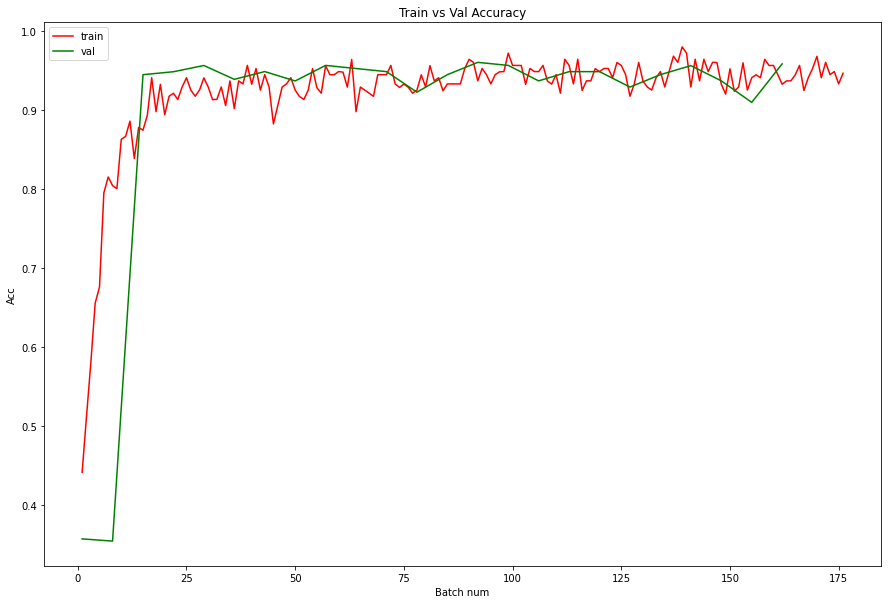

In [ ]:
make_graph_acc(classifier)

# Тест

Проверимся на валидационных данных еще раз, чтобы убедиться,
что сохранилась модель с лучшим результатом.

In [ ]:
trainer.test(classifier, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  test_accuracy_average     0.9467787146568298
    test_accuracy_f1        0.9466564521312925
        test_loss           0.12481135129928589
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_accuracy_average': 0.9467787146568298,
  'test_accuracy_f1': 0.9466564521312925,
  'test_loss': 0.12481135129928589}]

# Итог

Точность f1-score: **0.947**

Модель сохранена в: **"/content/drive/My Drive/модели/CatsDogs.pt"**